<a href="https://colab.research.google.com/github/auroramugnai/ArXivClassification/blob/main/ArXivClassification/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [ ]:
!git clone https://github.com/auroramugnai/ArXivClassification.git
%cd ArXivClassification/ArXivClassification

Cloning into 'ArXivClassification'...
remote: Enumerating objects: 1992, done.
remote: Counting objects: 100% (634/634), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 1992 (delta 469), reused 548 (delta 415), pack-reused 1358
Receiving objects: 100% (1992/1992), 71.06 MiB | 20.07 MiB/s, done.
Resolving deltas: 100% (1084/1084), done.
/content/ArXivClassification/ArXivClassification


# 1) Build the dataset

In [ ]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

from utils import text_cleaner

In [ ]:
SEED = 42 # fix random seed for reproducibility
random.seed(SEED)

## 1.1 Download the dataset
The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.28G/1.28G [00:19<00:00, 128MB/s] 
100% 1.28G/1.28G [00:19<00:00, 69.7MB/s]


Unzip the downloaded file.

In [ ]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [ ]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary information

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())

# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
# df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


## 1.3 Get a fixed number of articles
To speed up computation and avoid a session crash.

In [ ]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    df = df.sample(n=n_sample, axis=0, random_state=SEED)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 346827 articles.
The dataset contains 20000 articles.


# 2) Text processing

In [ ]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import en_core_web_md
import spacy
from tqdm import tqdm

In [ ]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
clean_abs = lambda x: text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(clean_abs, axis=1)

# Then on titles.
clean_tit = lambda x: text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(clean_tit, axis=1)

df.tail()

100%|██████████| 20000/20000 [03:12<00:00, 104.08it/s]


,id,title,category,abstract,clean_abstract,clean_title
117787,2305.01162,Role of bias and tunneling asymmetries in nonl...,"[cond-mat.mes-hall, cond-mat.str-el]",We study how bias and tunneling asymmetries ...,study bias tunneling asymmetry affect nonlinea...,role bias tunneling asymmetry nonlinear fermi ...
186643,2308.15190,Physical and behavioral comparison of haptic t...,[cs.HC],Touchscreens equipped with friction modulati...,touchscreens equip friction modulation provide...,physical behavioral comparison haptic touchscr...
30792,2207.10554,Solvability of the Poisson-Dirichlet problem w...,"[math.AP, math.CA]",We prove that the $L^{p'}$-solvability of th...,prove homogeneous dirichlet problem elliptic o...,solvability poisson dirichlet problem interior...
259834,2312.14468,FDA-MIMO-based Integrated Sensing and Communic...,[eess.SP],Considering that frequency diverse array mul...,consider frequency diverse array multiple inpu...,fda mimo base integrated sensing communication...
91737,2303.08355,Efficient and Secure Federated Learning for Fi...,"[cs.LG, cs.CR]",The conventional machine learning (ML) and d...,conventional machine learning ml deep learning...,efficient secure federated learning financial ...


In [ ]:
# Add a space to separate title and abstract.
df["clean_title"] = df["clean_title"].astype(str) + " "
df["text"] = df["clean_title"] + df["clean_abstract"]

# Save to csv.
# df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,text
210998,2310.05182,Nonequilibrium flow simulations using unified ...,"[physics.flu-dyn, physics.comp-ph]",Nonequilibrium flows are common in aerospace...,nonequilibrium flow common aerospace engineeri...,nonequilibrium flow simulation use unify gas k...,nonequilibrium flow simulation use unify gas k...
314811,2403.14135,Powerful Lossy Compression for Noisy Images,"[eess.IV, cs.CV]",Image compression and denoising represent fu...,image compression denoise represent fundamenta...,powerful lossy compression noisy images,powerful lossy compression noisy images image ...
4009,2004.06872,Degree spectra of homeomorphism types of compa...,[math.LO],A Polish space is not always homeomorphic to...,polish space homeomorphic computably present p...,degree spectra homeomorphism type compact poli...,degree spectra homeomorphism type compact poli...
236811,2311.10286,Dephasing of Strong-Field-Driven Floquet State...,"[physics.optics, cond-mat.mes-hall]","Floquet engineering, while a powerful tool f...",floquet engineering powerful tool ultrafast qu...,dephasing strong field drive floquet states re...,dephasing strong field drive floquet states re...
178721,2308.07268,Fault Tolerance in Euclidean Committee Selection,"[cs.GT, cs.CG, econ.TH]","In the committee selection problem, the goal...",committee selection problem goal choose subset...,fault tolerance euclidean committee selection,fault tolerance euclidean committee selection ...


# 3) Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import operator

# Count the occurrencies of words in texts.
def count_word_occurrences(series):
    word_count = {}

    # Iterate over all the elements in the series.
    for text in series:
    words = text.split() # split the texts in words
    for word in words:
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

    return word_count

texts = df['text']

# Compute the words occurrencies in all the texts.
word_occurrences = count_word_occurrences(texts)

# Sort words by occurrence (from the most common to the least common)
sorted_words = sorted(word_occurrences.items(), key=operator.itemgetter(1),
                      reverse=True)

# Choose the number of most common words to include as max_features.
max_features = 10000

# Extract the first max_features most common words.
common_words = [word for word, count in sorted_words[:max_features]]

# Convert the texts into a TF-IDF matrix.
tfidf_vectorizer = TfidfVectorizer(vocabulary=common_words)
X = tfidf_vectorizer.fit_transform(texts)
X.shape

(20000, 10000)

# 4) Dimensionality reduction with PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Reduce the dimensionality of the data to 3 for the 3D plot.
n_components = 3
pca = PCA(n_components=n_components, random_state=SEED)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(20000, 3)

In [ ]:
# Reduce the dimensionality of the data to 2 for the 2D plot.
pca2 = PCA(n_components=2, random_state=SEED)
X_reduced2 = pca2.fit_transform(X.toarray())
X_reduced2.shape

(20000, 2)

# 5) Find the number of clusters with K-Means

In [ ]:
!pip install kneed -q

In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from kneed import KneeLocator

<Figure size 640x480 with 0 Axes>

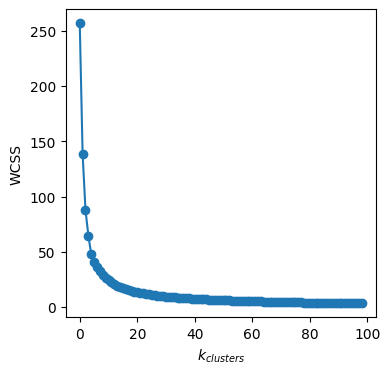

In [ ]:
# Perform the cluster algorithm k_max times and calculate the ssd from mean.
cluster_errors = []

k_max = 100
for i in range(1, k_max):
    n_clusters = i
    pipe_pca_kmean = Pipeline([("cluster", KMeans(n_init='auto',
                                                  n_clusters=n_clusters,
                                                  random_state=SEED,
                                                  verbose=0)
                                )])

    pipe_pca_kmean.fit(X_reduced2)
    pipe_pca_kmean.predict(X_reduced2)
    cluster_errors.append(pipe_pca_kmean.named_steps["cluster"].inertia_)

# Plot the sum squared distances from mean.
plt.clf()
plt.figure(figsize=(4,4))
plt.plot(cluster_errors, "o-")
plt.xlabel("$k_{clusters}$")
plt.ylabel("WCSS")
plt.show()

In [ ]:
# Find the optimal value of k with KneeLocator.
kl = KneeLocator(range(1, k_max), cluster_errors, curve="convex",
                 direction="decreasing")

# 6) Predict the clusters on our dataset

In [ ]:
k_optimal = kl.elbow

print('k_optimal = ', k_optimal)

k_optimal =  9


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Predict the clusters.
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=SEED, n_init='auto')
y_pred = kmeans.fit_predict(X_reduced)
y_pred2 = kmeans.fit_predict(X_reduced2)

## 6.1 Calculate clustering metrics

In [ ]:
import matplotlib.cm as cm
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples

The average silhouette score is: 0.38


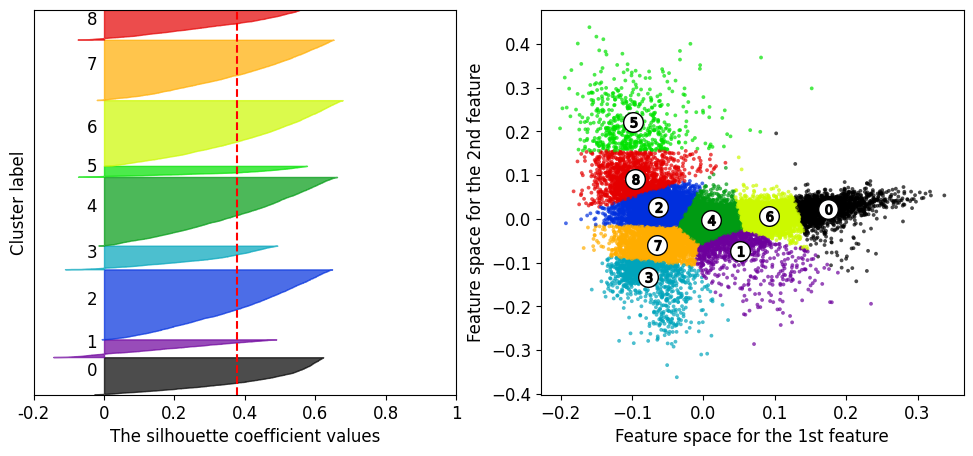

In [ ]:
n_clusters = k_optimal

# Create a subplot with 1 row and 2 columns.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
# fig.set_size_inches(22, 11)

# The first subplot is the silhouette plot.
ax1.set_xlim([-0.2, 1])
ax1.set_ylim([0, len(X_reduced2) + (n_clusters + 1) * 10])

# The silhouette_score gives the average value for all the samples.
silhouette_avg = silhouette_score(X_reduced2, y_pred2)
print("The average silhouette score is:", round(silhouette_avg, 2))

# Compute the silhouette scores for each sample.
sample_silhouette_values = silhouette_samples(X_reduced2, y_pred2)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[y_pred2 == i]
    # Sort them.
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                      ith_cluster_silhouette_values,
                      facecolor=color,
                      edgecolor=color,
                      alpha=0.7,
                      )

    # Label the silhouette plots with their cluster numbers at the middle.
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12)

    # Compute the new y_lower for next plot.
    y_lower = y_upper + 10

ax1.set_xlabel("The silhouette coefficient values", fontsize=12)
ax1.set_ylabel("Cluster label", fontsize=12)

# The vertical line for average silhouette score of all the values.
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=12)

# 2nd Plot showing the actual clusters formed.
colors = cm.nipy_spectral(y_pred2.astype(float) / n_clusters)
ax2.scatter(X_reduced2[:, 0], X_reduced2[:, 1], marker=".", s=30, lw=0,
            alpha=0.7, c=colors, edgecolor="k"
            )

# Labeling the clusters.
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers.
ax2.scatter(centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
            )

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_xlabel("Feature space for the 1st feature", fontsize=12)
    ax2.set_ylabel("Feature space for the 2nd feature", fontsize=12)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

# 7) Plot the clusters with UMAP


In [ ]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 792.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
import plotly.express as px
from umap import UMAP

In [ ]:
# UMAP definition.
umap_embeddings = UMAP(min_dist=0.1, n_components=n_components)
X_umap = umap_embeddings.fit_transform(X_reduced)


# Plot.
x, y, z = list(zip(*X_umap))
fig = px.scatter_3d(df, x, y, z, color=y_pred.astype(str),
                    color_discrete_sequence=px.colors.qualitative.Dark24,
                    hover_data=['category', 'title'])
fig.update_traces(marker_size=3)
fig.show()

In [ ]:
# Save interacting 3D plot as html.
fig.write_html('clustering_plot.html', auto_open=True)